# Outline of project

* Dataset being imported
* Visualize some aspect of the dataset
* Create Train and Validation dataset
* Create Our Vocabulary and tokenizer
* Create the Model
* setup the training loop for the model
* Visualizatoin of model prediction

Metrics Blue, Earlystoping as per paper,  


## Imports

In [1]:
import numpy as np
import os, random
import pandas as pd
import spacy
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, unpad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.transforms import transforms
from torchvision.models import vgg19
from tqdm import tqdm
from torchsummary import torchsummary
import torch.nn.functional as F
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from nltk.translate.bleu_score import corpus_bleu

## Data Visualization

As per dataset decription, each image has 5 captions avaialable let's see a few of them and how they look like

In [2]:
def load_dataset_dict(caption_path):
    df = pd.read_csv(caption_path)
    caption_dict = defaultdict(list)
    for _, row in df.iterrows():
        caption_dict[row.image].append(row.caption)
    return caption_dict

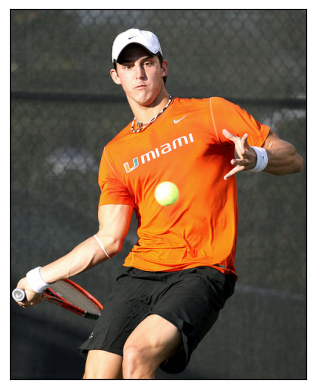

A man about to hit a tennis ball with a racket .
A man in an orange shirt playing tennis .
A man in an orange t-shirt and white wristbands plays tennis .
a man wearing an orange U. Miami t-shirt playing tennis
A tennis player in an orange shirt is lining up his racquet to strike the ball .


In [3]:
image_id, captions = random.choice(list(load_dataset_dict("data/captions.txt").items()))
data_dir = "data/images"
full_image_path = os.path.join(data_dir, image_id)
image = Image.open(full_image_path)
plt.xticks([])
plt.yticks([])
plt.imshow(image)
plt.show()
for caption in captions:
    print(caption)


## EDA

In [4]:
df = pd.read_csv("data/captions.txt")
df_captions = df.caption

In [5]:
def count_words(df):
    vocabulary = []
    for txt in df.caption.values:
        vocabulary.extend(txt.split())
    counter = defaultdict(int)

    for word in vocabulary:
        counter[word.lower()] += 1
    sorted_items = sorted(counter.items(), key=lambda item: item[-1], reverse=True)


    df = pd.DataFrame(sorted_items, columns=['word', 'count'])

    return df

df_counter = count_words(df)

In [6]:
df_counter.head(10)

,word,count
0,a,62986
1,.,36577
2,in,18974
3,the,18418
4,on,10743
5,is,9345
6,and,8851
7,dog,8136
8,with,7765
9,man,7265


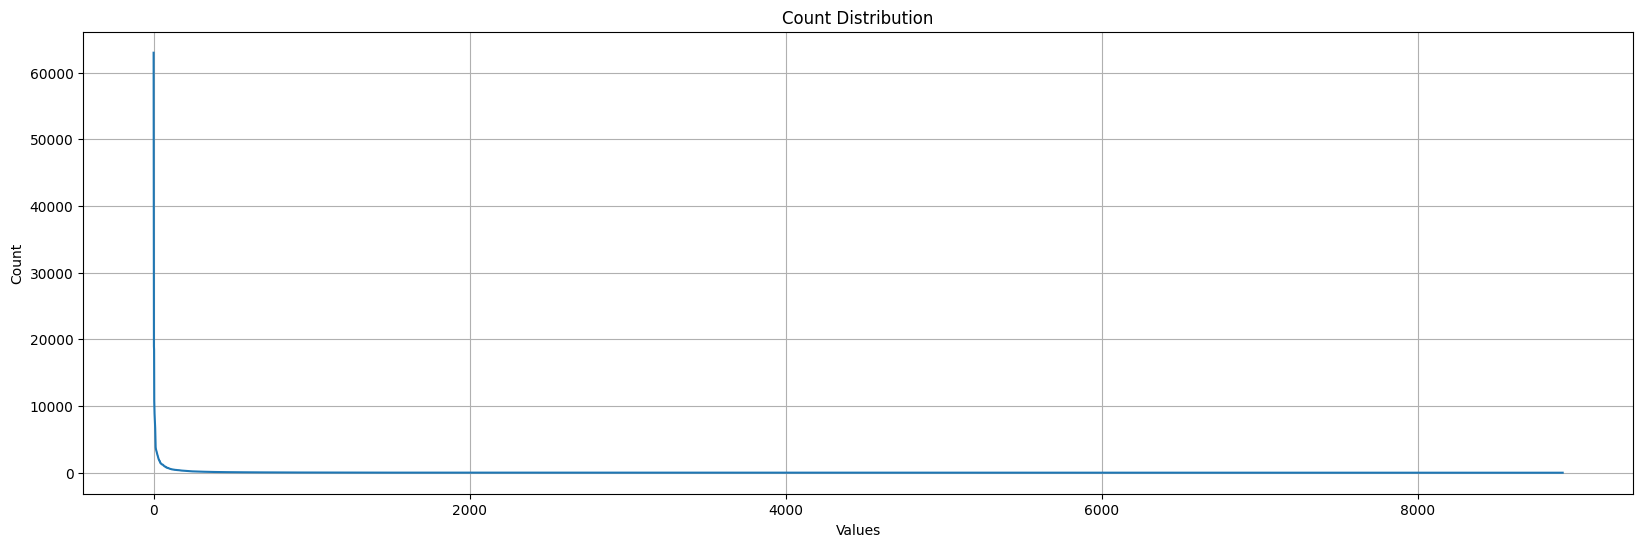

In [7]:
df_counter["count"].plot(grid=True, figsize=(20, 6))
plt.title("Count Distribution")
plt.xlabel("Values")
plt.ylabel("Count")
plt.show()

Text(0.5, 1.0, 'plot of count vs words')

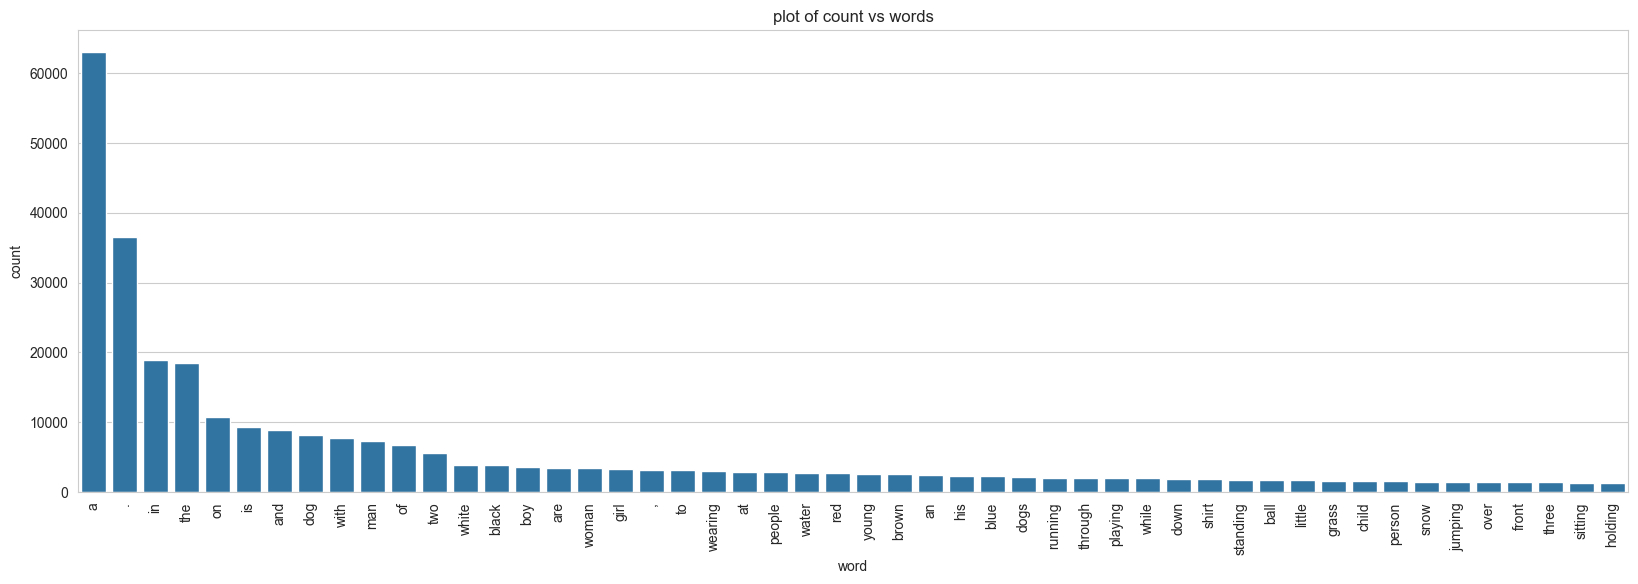

In [8]:
sns.set_style(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(data=df_counter[:50], y='count', x="word")
plt.xticks(rotation="vertical")
plt.title("plot of count vs words")

In [9]:
"My name is Nathan".split()

['My', 'name', 'is', 'Nathan']

In [14]:
nlp = spacy.load("en_core_web_sm")
df['cal_len'] = df['caption'].apply(lambda x: len(nlp.tokenizer(x)))


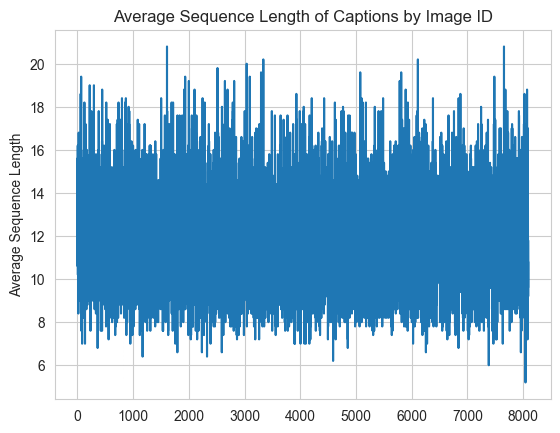

In [ ]:
nlp = spacy.load("en_core_web_sm")
df['sequence_length'] = df['caption'].apply(lambda x: len(nlp.tokenizer(x)))

# Step 3: Group by 'image_id' and calculate the average sequence length
avg_sequence_length = df.groupby('image')['sequence_length'].mean().reset_index()
avg_sequence_length['sequence_length'].plot()
plt.ylabel('Average Sequence Length')
plt.title('Average Sequence Length of Captions by Image ID')
plt.show()

## Train, Val Split

In [4]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

In [5]:
df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [6]:
for i in train_data.values():
    for j in i:
        print(j)
    break

A blonde girl in a black cape stands with other children in costumes .
A girl in a black cape with a group of other children
A girl in a cape along with other costumed children
A group of children dressed for halloween stand in line with the exception of one girl .
Children in costumes standing in line .


In [14]:
hash_map = set()
for caption_list in train_data.values():
    for caption in caption_list:
        for word in caption.split():
            hash_map.add(word.lower())
len(hash_map)


8079

In [9]:
hash_map_val = set()
for caption_list in val_data.values():
    for caption in caption_list:
        for word in caption.split():
            hash_map_val.add(word.lower())
len(hash_map_val)

4127

In [12]:
hash_map_val.issubset(hash_map)

False

In [16]:
print(len(hash_map_val.difference(hash_map)))

839


*Note*: all the words in train are also in out test data

## Vocabulary and tokenizer

In [17]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 8.2 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [18]:

class Vocabulary():
    spacy_eng = spacy.load("en_core_web_sm")

    
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold

    
    def __len__(self):
        return len(self.itos)


    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in Vocabulary.spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self, sentence_list):
        frequency = {}
        idx = 4

        for sentence in sentence_list:
            for token in self.tokenizer_eng(sentence):

                frequency[token] = 1 + frequency.get(token, 0)

                if frequency[token] == self.freq_threshold:
                    self.stoi[token] = idx
                    self.itos[idx] = token
                    idx += 1
    
    def tokenize(self, text):
        token_sent = self.tokenizer_eng(text)

        return [self.stoi[token] if token in self.stoi else self.stoi['<UNK>']
                for token in token_sent
            ]
    
    def vocabulary_size(self):
        return len(self.stoi)

In [19]:
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocabulary.vocabulary_size()

8508

In [20]:
vocabulary.tokenize("creates a human whose, name is not Tom James")

[5587, 4, 2634, 3150, 139, 7346, 9, 2183, 3, 3]

In [21]:
[vocabulary.itos[idx] for idx in [5587, 4, 2634, 3150, 139, 7346, 9, 2183, 3, 3]]

['creates', 'a', 'human', 'whose', ',', 'name', 'is', 'not', '<UNK>', '<UNK>']

In [22]:
vocabulary.stoi["<PAD>"]

0

In [23]:
class FlickrDataset(Dataset):

    def __init__(self, image_dir, vocabulary: Vocabulary, data_dict, transform=None, train=True):
        self.data_dict = data_dict
        self.transform = transform
        self.image_dir = image_dir


        self.train = train
        self.item = self.setup_item()
        
        self.vocabulary = vocabulary

    
    def setup_item(self):
        item = []
        if self.train:
            for image_id, image_captions in self.data_dict.items():
                for caption in image_captions:
                    item.append((image_id, caption))
        else:
            for image_id, image_captions in self.data_dict.items():
                item.append((image_id, image_captions))
        return item

    def __len__(self):
        return len(self.item)


    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.item[index][0])
        img = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        caption = self.item[index][1]
        if self.train:
            num_caption = [self.vocabulary.stoi['<SOS>']]
            num_caption += self.vocabulary.tokenize(caption)
            num_caption.append(self.vocabulary.stoi['<EOS>'])
            num_caption = torch.tensor(num_caption)
            return img, num_caption
        else:
            captions = []
            for cap in caption:
                num_caption = [self.vocabulary.stoi['<SOS>']]
                num_caption += self.vocabulary.tokenize(cap)
                num_caption.append(self.vocabulary.stoi['<EOS>'])
                captions.append(torch.tensor(num_caption))
            return img, pad_sequence(captions, batch_first=False, padding_value=0)
        

In [24]:
class MyCollate:
    def __init__(self, pad_idx, train=True):
        self.pad_idx = pad_idx
        self.train = train
    
    def __call__(self, batch): # pad sequnece
        img = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(img, 0)
        target = [item[1] for item in batch]
        if self.train:
            target = pad_sequence(target, batch_first=True, padding_value=self.pad_idx)
        else:
            #for i in target:
            #    print(i.shape)
            target = pad_sequence(target, batch_first=True, padding_value=self.pad_idx)
            target=target.permute(0, 2, 1).contiguous() #get back to regular batch_first = True

        return img, target

In [25]:
def get_loader(
        image_folder,
        data_dict,
        vocabulary,
        transform,
        train=True,
        batch_size=32,
        num_worker=0,
        shuffle=True,
        pin_memory=True
):
    dataset = FlickrDataset(image_dir=image_folder, vocabulary=vocabulary, data_dict=data_dict,
                            transform=transform, train=train)
    pad_idx = vocabulary.stoi["<PAD>"]
    
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=MyCollate(pad_idx=pad_idx, train=train),
        pin_memory=pin_memory,
        shuffle=shuffle,
        num_workers=num_worker,
    )

    return loader, dataset

In [26]:
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocabulary.vocabulary_size()

8508

In [27]:
folder = "data/images/"
df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [28]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

In [29]:
train_dataset = FlickrDataset(image_dir=folder, vocabulary=vocabulary, data_dict=train_data,
                        transform=transform, train=True)

In [30]:
random_index = random.randint(0, len(train_dataset) - 1)

# Get the random element
random_image, random_label = train_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)

Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([15])


In [31]:
val_dataset = FlickrDataset(image_dir=folder, vocabulary=vocabulary, data_dict=val_data,
                        transform=transform, train=False)

In [32]:
random_index = random.randint(0, len(val_dataset) - 1)

# Get the random element
random_image, random_label = val_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", len(random_label), random_label.shape)
## using list of sequence with training = False (not tensor and pad)

Random Shape: torch.Size([3, 224, 224])
Random Caption: 18 torch.Size([18, 5])


In [33]:
val_loader, _ = get_loader(image_folder=folder, data_dict=val_data, vocabulary=vocabulary, transform=transform, train=False)

for image, caption in val_loader:
    print(caption.shape)
    print(image.shape)
    index = random.randint(0, 31)
    first_image = image[index]
    print(first_image.shape)
    first_caption = caption[index]
    print(first_caption.shape)
    #plt.imshow(first_image.permute(1,2,0))
    #for i in range(len(first_caption)):
    #    caption = [vocabulary.itos[element] for element in first_caption[i].tolist()]
    #    print(caption)
    break

torch.Size([32, 5, 29])
torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([5, 29])


## Model

### Encoder

#### Test

In [ ]:
model = vgg19("VGG19_Weights.IMAGENET1K_V1")

/Users/ngkuissi/miniforge3/envs/image_cap/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/ngkuissi/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
 67%|██████▋   | 365M/548M [00:45<00:19, 9.99MB/s] 

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
list(model.features.children())

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1

In [ ]:
# Path to your image file
image_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)

modules = list(model.features.children())[:-1]
test_model = nn.Sequential(*modules)

output = test_model(image_tensor)
print(output.shape)
print(image_tensor.shape)

torch.Size([1, 512, 14, 14])
torch.Size([1, 3, 224, 224])


#### Model

In [ ]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        self.net = vgg19(pretrained=True)
        self.model = nn.Sequential(*list(self.net.features.children())[:-1])
        self.dim = 512
    
    def fine_tine(self, finetune=False):
        for param in self.model.parameters():
            param.requires_grad = finetune
    
    def forward(self, images):
        out = self.model(images)
        out = out.permute(0, 2, 3, 1)
        out = out.view(out.size(0), -1, out.size(-1))
        return out

### Test

In [ ]:
image_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
enocder = Encoder()
output = enocder(image_tensor)
print("encoded image shape: ", output.shape)

# caption
caption = "A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel ."
caption = vocabulary.tokenize(caption)
caption = torch.tensor(caption).unsqueeze(0)
print("tokenize caption shape:", caption.shape)

# embedding the caption
embedding = nn.Embedding(vocabulary.vocabulary_size(), 64)
caption = embedding(caption)
print("embedded caption shape:", caption.shape)

# initlize your values for h and c
init_h = nn.Linear(512, 256)
init_c = nn.Linear(512, 256)

average_out = output.mean(dim=1)
h = init_h(average_out)
c = init_c(average_out)
print("shape of average encoder output:", average_out.shape)
print("shape of initial h:", h.shape)
print("shape of inital c:", c.shape)

## initilizeing predictions and alpha (will be returned)
prediction = torch.zeros(1, caption.shape[1], vocabulary.vocabulary_size())


## Attention
encoder_attention = nn.Linear(512, 128)
decorder_attention = nn.Linear(256, 128)
attend = nn.Linear(128, 1)

# Decoder
lstm = nn.LSTMCell(512+64, 256)
fc = nn.Linear(256, vocabulary.vocabulary_size())



for i in range(caption.shape[1]):
        
        ## attention forward method
        tmp_img = encoder_attention(output)
        tmp_h = decorder_attention(h).unsqueeze(1)
        print("encoder output attention shape:", {tmp_img.shape})
        print("hidden output attention shape:", {tmp_h.shape})
        add = nn.Tanh()(tmp_img + tmp_h)
        print("Sum of enocder and hidden output shape: ", {add.shape})
        att = attend(add).squeeze(2)
        print("non scaled attention score shape:", {att.shape})
        alpha = nn.Softmax(dim=1)(att)
        print("alpha shape:", alpha.shape)
        weighted_context = (output * alpha.unsqueeze(2))
        print("unsqueze weight context shape:", weighted_context.shape)
        weighted_context = weighted_context.sum(dim=1)
        print("full weighted context shape:", {weighted_context.shape})
        
        print("--------- DONE CALCULATING ATTENTION SCORE -----------")
        print(caption[:,i,:].shape)
        lstm_input = torch.cat([caption[:,i,:], weighted_context], dim=1)
        print(lstm_input.shape)
        h, c = lstm(lstm_input, (h, c))
        word_prop = fc(h)
        print("word_proabability shape:", word_prop.shape)
        prediction[:,i,:] = word_prop

print("--------- DONE DECORDER -----------")
print("final predictions shape:", {prediction.shape}) 



/Users/ngkuissi/miniforge3/envs/ImageCap/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


encoded image shape:  torch.Size([1, 196, 512])


NameError: name 'vocabulary' is not defined

### Attention

In [ ]:
class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha
    

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, embed_dim, attention_dim, encoder_dim, decoder_dim, vocab_size):

        super(Decoder, self).__init__()
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout()

        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)

        self.output = nn.Linear(decoder_dim, vocab_size)
        self.vocab_size = vocab_size

    
    def init_hidden_state(self, encoder_out: torch.Tensor):
        average_out = encoder_out.mean(dim=1)
        h = self.init_h(average_out)
        c = self.init_c(average_out)
        return h, c
    

    def forward(self, encoder_out, caption):
        print("first image encoder out:", encoder_out[0,80:120,230:271]) #enocder out for first image
        #print("sum of first enocder out:", encoder_out[0].sum(dim=-1))

        embeddings = self.embedding(caption)

        h, c = self.init_hidden_state(encoder_out)
        print("First hidden and h:", h[0])
        print("First c to go into lstm:", c[0])
        device = h.device

        predictions = torch.zeros(caption.shape[0], caption.shape[1], self.vocab_size).to(device)
        alphas = torch.zeros(caption.shape[0], caption.shape[1], encoder_out.shape[1]).to(device)

        for i in range(caption.size(-1)):
            weighted_context, alpha = self.attention(encoder_out, h)
            #gate = self.sigmoid(self.f_beta(h))
            #weighted_context = gate * weighted_context
            lstm_input = torch.cat([embeddings[:,i,:], weighted_context], dim=1)
            h, c = self.lstm(lstm_input, (h, c))
            word_prop = self.output(self.dropout(h))
            
            for j in range(word_prop.size(0)):
                predictions[j,i] = word_prop[j]
            alphas[:,i,:] = alpha
                
        print("fist prediction: ", predictions[0])
        print("first alpha:", alphas[0])
        print("alpha sum", alphas[0].max(dim=1))
        return predictions, alphas


### test decoder

In [ ]:
mage_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
enocder = Encoder()


# caption
caption = "A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel ."
caption = vocabulary.tokenize(caption)
caption = torch.tensor(caption).unsqueeze(0)


output = enocder(image_tensor)
decoder = Decoder(512, 256, 512, 256, vocabulary.vocabulary_size())
preds, als = decoder(output, caption)

### Caption

In [ ]:
class Caption(nn.Module):
    def __init__(self, embed_dim, attention_dim, encoder_dim, decoder_dim, vocab_size):
        super(Caption, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(embed_dim=embed_dim, attention_dim=attention_dim,
                               encoder_dim=encoder_dim, decoder_dim=decoder_dim, vocab_size=vocab_size)
        self.encoder.fine_tine()
    
    def forward(self, img, captions):
        features = self.encoder(img)
        predictions, alphas = self.decoder(features, captions)
        return predictions, alphas

    def caption_img(self, img, vocab, max_length=100):
        result_caption = []

        with torch.no_grad():
            feature = self.encoder(img) 
            h, c = self.decoder.init_hidden_state(feature)

            ## first input to the model
            start = torch.zeros(size=(1,), dtype=torch.int)
            start[0] = vocabulary.stoi['<SOS>']
            start = start.unsqueeze(0)
            start = start.to(h.device)
            embeddings = self.decoder.embedding(start).squeeze(0)
            ##print(embeddings.shape)

            for _ in range(max_length):
                weighted_context, alpha = self.decoder.attention(feature, h)
                gate = self.decoder.sigmoid(self.decoder.f_beta(h))
                weighted_context = gate * weighted_context
                #print(weighted_context.shape)
                lstm_input = torch.cat([embeddings, weighted_context], dim=1)
                #print(lstm_input.shape)

                h, c = self.decoder.lstm(lstm_input, (h, c))
                #print(h.shape)
                output = self.decoder.output(h.squeeze(0)) # removing the extra dimension needed in lstm
                #print(output.shape)
                predicted = output.argmax(0) # highest probablities word
                result_caption.append(predicted.item())
                embeddings = self.decoder.embedding(predicted).unsqueeze(0)
                #print(embeddings.shape)
                if vocab.itos[predicted.item()] == "<EOS>":
                    break
            
            return [vocab.itos[idx] for idx in result_caption] #return the final sentence

    def beam_search(self, img, k, vocab):
        with torch.no_grad():
            encoder_out = self.encoder(img) # (1, num_pixels, encoder_dim)
            num_pixels = encoder_out.size(1)

            encoder_dim = encoder_out.size(-1)



            # we'll treat the problem as having a batch size of k
            encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)    # (k, num_pixels, encoder_dim)

            # tensor to store top k previous words at each step; now they're just <SOS> token
            top_k_prev_words = torch.tensor([[vocabulary.stoi['<SOS>']]] * k, dtype=torch.long)  # (k, 1)

            # tensor to store top k sequences for the entire algorithm; now they're just <start>
            top_k_seqs = top_k_prev_words

            # tensor to store top k sequences' scores; now they're just 0
            top_k_scores = torch.zeros(k, 1)

            # tensor to store top k sequences' alphas; now they're just 1s
            top_k_seqs_alpha = torch.ones(k, 1, num_pixels) #(k, 1, enc_image_size)

            # lists to store completed sequences along with their alphas and scores
            complete_seqs = []
            complete_seqs_alpha = []
            complete_seqs_scores = []

            ## Actual decoding step
            step = 1
            h, c = self.decoder.init_hidden_state(encoder_out) 

            # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
            while True:
                embeddings = self.decoder.embedding(top_k_prev_words).squeeze(1) # (s, embed_dim)
                weighted_context, alpha = self.decoder.attention(encoder_out, h)
                gate = self.decoder.sigmoid(self.decoder.f_beta(h))
                weighted_context = gate * weighted_context

                lstm_input = torch.cat([embeddings, weighted_context], dim=1)
                h, c = self.decoder.lstm(lstm_input, (h, c)) # (s, decoder_dim)

                scores = self.decoder.output(h)      # (s, vocab_size)
                scores = F.log_softmax(scores, dim=1)

                #
                scores = top_k_scores.expand_as(scores) + scores    # (s, vocab_size)
                # all the k points will have the same score for the first step (since same k previous words, h, c)
                if step == 1:
                    top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)    # (s)
                else:
                    # unroll and find top scores, and their unrolled indices
                    top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)    # (s)
                
                # convert unrolled indices to actual indices of scores
                prev_word_idx = top_k_words // len(vocab)
                next_word_idx = top_k_words % len(vocab)

                # add new words to sequences, alphas
                top_k_seqs = torch.cat([top_k_seqs[prev_word_idx], next_word_idx.unsqueeze(1)], dim=1) # (s, step + 1)
                top_k_seqs_alpha = torch.cat([top_k_seqs_alpha[prev_word_idx], alpha[prev_word_idx].unsqueeze(1)], dim = 1)

                # which sequences are incomplete (didn't reach <EOS>)?
                incomplete_idx = [idx for idx, next_word in enumerate(next_word_idx)
                                  if next_word != vocab.stoi['EOS']]
                complete_idx = list(set(range(len(next_word_idx))) - set(incomplete_idx))

                # set aside complete sequences
                if len(complete_idx)>0:
                    complete_seqs.extend(top_k_seqs[complete_idx].to_list())
                    complete_seqs_alpha.extend(top_k_seqs_alpha[complete_idx].to_list())
                    complete_seqs_scores.extend(top_k_scores[complete_idx].to_list())
                k -= len(complete_idx)

                # update the remaning values to only deal with incomplete sentences
                top_k_seqs = top_k_seqs[incomplete_idx]
                top_k_seqs_alpha = top_k_seqs_alpha[incomplete_idx]
                top_k_scores = top_k_scores[incomplete_idx].unsqueeze(1)
                top_k_prev_words = next_word_idx[incomplete_idx].unsqueeze(1)

                encoder_out = encoder_out[prev_word_idx[incomplete_idx]]
                h= h[prev_word_idx[incomplete_idx]]
                c = c[prev_word_idx[incomplete_idx]]

                if step > 50:
                    break
                step += 1



## Training Loop

In [ ]:
def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [ ]:
def train_epoch(train_loader, captioner: Caption, device, criterion, optimizer, alpha_c, epoch):
    losses = []

    captioner.train()

    for idx, (imgs, caps) in enumerate(tqdm(train_loader, total=len(train_loader))):
        # move tensor to device if available
        imgs = imgs.to(device)
        caps = caps.to(device)

        optimizer.zero_grad()

        # forward prop
        predictions, alphas = captioner(imgs, caps)

        
        #att_regularization = alpha_c * ((1 - alphas.sum(1))**2).mean()
        loss = criterion(predictions.view(-1, predictions.size(-1)), caps.view(-1)) #+ att_regularization

        loss.backward()
        #torch.nn.utils.clip_grad_norm_(captioner.parameters(), max_norm=1.)
        optimizer.step()

        # keep track of metrics
        losses.append(loss.item())
        break
        

    print('Training Epoch #: [{0}]\t'
        'Loss: {loss:.4f}\t'.format(
                epoch, loss=np.mean(losses)))

    return np.mean(losses)



    

In [ ]:
def val_epoch(val_loader, captioner, criterion, device, optimizer, alpha_c, epoch):
    captioner.eval()
    losses = []
    references = []
    hypothesis = []
    with torch.no_grad():
        for idx, (images, captions) in enumerate(tqdm(val_loader, total=len(val_loader))):
            images = images.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            # forward prop
            predictions, alphas = captioner(images, captions[:,0,:])

            att_regularization = alpha_c * ((1 - alphas.sum(1))**2).mean()
            temp_cap = captions[:,0,:]
            loss = criterion(predictions.view(-1, predictions.size(-1)), temp_cap.reshape(-1)) + att_regularization

            # keep track of metrics
            losses.append(loss.item())

            for references_idx in range(captions.size(0)):
                possible_caption = []
                for sub_caption_reference_idx in range(captions[references_idx].size(0)):
                    reference = [vocabulary.itos[caption] for caption in captions[references_idx][sub_caption_reference_idx].tolist()
                                if caption != vocabulary.stoi['<SOS>'] and caption != vocabulary.stoi['<PAD>']]
                    possible_caption.append(reference)
                
                references.append(possible_caption)

            words_idx = predictions.argmax(dim=-1)
            for hypothesis_idx in range(words_idx.size(0)):
                hypothes = [vocabulary.itos[caption.item()] for caption in words_idx[hypothesis_idx] if
                             caption != vocabulary.stoi['<SOS>'] and caption != vocabulary.stoi['<PAD>']]
                hypothesis.append(hypothes)
            break
            
            

    bleu_1 = corpus_bleu(references, hypothesis, weights=(1, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hypothesis, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(references, hypothesis, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(references, hypothesis)
    
    print('Validation Epoch #: [{0}]\t'
            'Loss {loss:.4f}\t'
            'bleu_1 {bleu_1}\t'
            'bleu_2 {bleu_2}\t'
            'bleu_3 {bleu_3}\t'
            'bleu_4 {bleu_4}\t'.format(
                epoch, len(val_loader), loss=np.mean(losses), bleu_1=bleu_1, bleu_2=bleu_2, bleu_3=bleu_3, bleu_4=bleu_4))
    
    return np.mean(losses),bleu_1, bleu_2, bleu_3, bleu_4, hypothesis, references

In [ ]:
# model parameters

embed_dim = 64
attention_dim = 64
decoder_dim = 64
encoder_dim = 512
learning_rate = 1e-7
alpha_c = 1.
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocab_size = len(vocabulary)
epochs = 100
best_blue_4 = 0
path = "model/best_model.pth"



In [ ]:
device = "cpu"
if torch.cuda.is_available():
    device = "cpu"
elif torch.backends.mps.is_available():
    device="mps"

# Model
model = Caption(embed_dim=embed_dim, attention_dim=attention_dim, encoder_dim=encoder_dim,
                decoder_dim=decoder_dim, vocab_size=vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocabulary.stoi["<PAD>"])
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=learning_rate)

/Users/ngkuissi/miniforge3/envs/ImageCap/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ngkuissi/miniforge3/envs/ImageCap/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
folder = "data/images/"
train_loader, _ = get_loader(data_dict=train_data, transform=transform, vocabulary=vocabulary, image_folder="data/images/")
val_loader, _ = get_loader(image_folder=folder, data_dict=val_data, vocabulary=vocabulary, transform=transform, train=False)
train_losses = []
test_losses = []


bleu_1s = []
bleu_2s = []
bleu_3s = []
bleu_4s = []
for epoch in range(epochs):

    loss = train_epoch(train_loader=train_loader, captioner=model, device=device,
                            criterion=criterion, optimizer=optimizer, alpha_c=alpha_c, epoch=epoch)
    
    train_losses.append(loss)

    #loss, bleu_1, bleu_2, bleu_3, bleu_4, hypothesis, references = val_epoch(val_loader=val_loader,
    #                                                                              captioner=model, criterion=criterion, device=device, optimizer=optimizer, 
    #                                                                              alpha_c=alpha_c, epoch=epoch)
    #test_losses.append(loss)
    #bleu_1s.append(bleu_1)
    #bleu_2s.append(bleu_2)
    #bleu_3s.append(bleu_3)
    #bleu_4s.append(bleu_4)


    #if bleu_4 > best_blue_4:
    #    print("epoch lead to better model, saving to selected path")
    #    torch.save(model.state_dict(), path)
    #break

    


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0585],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.6241],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 4.3920],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.5102]],
       device='mps:0')
First hidden and h: tensor([-0.0958,  0.3254,  0.1122, -0.3132,  0.2305, -0.0021,  0.0476, -0.2164,
        -0.3184, -0.2792,  0.0292, -0.0199,  0.2455,  0.1514, -0.0183,  0.1874,
         0.2820,  0.2153,  0.1071, -0.0741,  0.0171,  0.1026,  0.1915,  0.0811,
        -0.1086,  0.0948, -0.4262,  0.0889, -0.0381, -0.0161, -0.0682, -0.0038,
        -0.1436,  0.0779,  0.1003,  0.1939,  0.1815,  0.3028, -0.0097,  0.0998,
         0.0533, -0.0928, -0.0486,  0.0484,  0.2861,  0.3055, -0.0693,  0.0783,
        -0.0349, -0.0394,  0.1091, -0.0973,  0.3816,  

  0%|          | 0/1012 [00:01<?, ?it/s]


Training Epoch #: [0]	Loss: 9.1644	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 6.2506e-02,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.6565e-01, 1.3022e+00,
         0.0000e+00],
        [0.0000e+00, 3.4450e+00, 0.0000e+00,  ..., 2.9087e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.8088e+00],
        [2.5090e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.2137e+00],
        [6.8586e+00, 0.0000e+00, 9.4372e-01,  ..., 0.0000e+00, 0.0000e+00,
         6.2247e-03]], device='mps:0')
First hidden and h: tensor([ 2.9042e-01,  1.3384e-01, -6.7598e-02, -1.9623e-01,  4.1658e-01,
         2.3102e-01,  1.2056e-01, -3.7377e-02, -1.0873e-01, -9.7436e-02,
        -5.7916e-02, -3.2681e-01, -8.7782e-02,  4.3315e-02,  3.9433e-03,
        -8.5435e-02,  5.3354e-02,  2.4825e-01,  2.3055e-01, -2.5875e-01,
         2.8316e-02,  5.1337e-02,  1.1756e-01,  1.2

  0%|          | 0/1012 [00:00<?, ?it/s]


Training Epoch #: [1]	Loss: 9.1850	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.5978, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4168, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6471, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 3.4242, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7586, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
First hidden and h: tensor([ 0.1068,  0.0153, -0.0892,  0.0259,  0.4167, -0.1091,  0.1108, -0.1645,
         0.0742, -0.0849, -0.3514, -0.1990,  0.1000, -0.0901, -0.1731,  0.0509,
         0.2603, -0.0366,  0.0258, -0.2229,  0.2433,  0.0205,  0.2353,  0.0296,
         0.0484,  0.3646, -0.6052,  0.3505,  0.1244, -0.1198,  0.0341,  0.0375,
        -0.0750, -0.4045, -0.1736, -0.0328,  0.1856,  0.3385,  0.4258,  0.0666,
        -0.1103, -0.2546, -0.2880,  0.1110,  0.1876,  0.1970, -0.0154,  0.1845,
         0.1965,  0.0232, -0.1201, -0.3279, -0.0676,  

  0%|          | 0/1012 [00:00<?, ?it/s]


Training Epoch #: [2]	Loss: 9.1596	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='mps:0')
First hidden and h: tensor([-0.0333,  0.0851,  0.1489, -0.0907, -0.0686,  0.0889,  0.0011,  0.0895,
         0.1085, -0.0108,  0.0396, -0.0512, -0.0434, -0.0972,  0.0251, -0.0146,
         0.0784,  0.1065, -0.0463, -0.0710,  0.1369,  0.1290,  0.0931, -0.0176,
         0.0336, -0.0877, -0.1422,  0.1262,  0.1376, -0.1201,  0.0076, -0.1085,
         0.0059, -0.0679, -0.0729,  0.1535,  0.0834,  0.0780, -0.0355,  0.0241,
        -0.0089, -0.1976,  0.0339, -0.0892,  0.1913, -0.1224, -0.1045,  0.2113,
         0.0877,  0.0693,  0.0299, -0.0833, -0.0113,  0.0846, -0.2282,  0.0704,
         0.1858,  0.0458, -0.1148,  0.0782,  0.0585,  0.0810, -0.1470,  0.0019],
       device='mps:0', grad_fn=<SelectBackwa

  0%|          | 0/1012 [00:01<?, ?it/s]


Training Epoch #: [3]	Loss: 9.1229	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.3010, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.5922],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 6.3074],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 4.8474]],
       device='mps:0')
First hidden and h: tensor([ 3.4458e-01, -1.3951e-01,  5.4400e-01, -2.5391e-01, -7.5818e-02,
         2.2777e-01,  2.7222e-01, -1.6172e-01,  4.1230e-02, -2.0872e-01,
        -2.8010e-02,  3.6690e-02,  9.2262e-02, -2.8145e-01, -5.8515e-02,
         3.6674e-01,  3.7094e-01, -2.2184e-02, -5.0315e-02, -1.4810e-01,
         1.1315e-01, -5.2491e-02,  2.6950e-01, -1.9954e-01,  4.5624e-02,
        -4.7932e-01, -4.4950e-01,  2.1394e-01,  2.8690e-01, -3.1076e-01,
        -4.5713e-04, -2.3333e-01,  1.1293e-01, -1.4694e-01, -2.7604e-02,
        -1.0970e-01,  5

  0%|          | 0/1012 [00:01<?, ?it/s]


Training Epoch #: [4]	Loss: 9.1497	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.0229],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 3.0791, 0.0000,  ..., 0.1452, 0.0000, 1.8136],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.9956, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
First hidden and h: tensor([ 0.1060, -0.1320,  0.1087,  0.0916, -0.2938, -0.0238,  0.0776, -0.0047,
        -0.0975,  0.0210,  0.1496, -0.0607, -0.1268,  0.3473, -0.0105,  0.2272,
         0.4090,  0.3538,  0.1595, -0.0197, -0.0075, -0.0653,  0.3381,  0.2489,
         0.0131, -0.1898, -0.1813,  0.2370, -0.1615,  0.1475,  0.0587, -0.0198,
         0.1298, -0.2071,  0.0936,  0.1324,  0.3629,  0.2851, -0.1324, -0.0669,
         0.0740,  0.0441,  0.1108,  0.1018,  0.1474,  0.1241, -0.0192,  0.1503,
         0.1675,  0.1570,  0.3048,  0.1919,  0.1587,  

  0%|          | 0/1012 [00:00<?, ?it/s]


Training Epoch #: [5]	Loss: 9.1712	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.0000, 0.2583,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3811,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
First hidden and h: tensor([ 2.6818e-02,  8.0883e-02,  3.7479e-01,  1.1474e-02, -9.5667e-02,
         2.2294e-01,  1.7496e-01,  6.7476e-02,  2.0800e-01, -8.7865e-02,
        -2.7179e-04,  1.3485e-02,  7.9758e-02,  1.9667e-01,  1.7494e-02,
         1.1030e-01,  1.0211e-01,  5.5425e-02,  1.5881e-01, -4.1858e-02,
         1.1586e-01,  1.1240e-01,  2.4030e-02,  2.6451e-01,  6.2445e-02,
        -1.1838e-01, -2.4857e-01,  1.2607e-01,  8.7370e-02, -7.2367e-02,
         1.0300e-02, -1.3042e-01, -6.9397e-02,  3.1039e-02, -7.2570e-02,
        -1.6944e-02,  1

  0%|          | 0/1012 [00:01<?, ?it/s]


Training Epoch #: [6]	Loss: 9.1397	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0583],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.1382]],
       device='mps:0')
First hidden and h: tensor([-0.3230,  0.1704, -0.0752, -0.0918,  0.3817, -0.2232, -0.0091, -0.2875,
        -0.1803, -0.5847, -0.4767,  0.0234, -0.0900, -0.2821, -0.3900, -0.0519,
         0.1602,  0.1498, -0.0432, -0.2677, -0.0044,  0.2910, -0.0804,  0.0411,
         0.1871,  0.4460, -0.4802,  0.5665,  0.0566, -0.1130,  0.4196,  0.3016,
        -0.5177, -0.5745, -0.0249,  0.1682,  0.3440,  0.2526, -0.0142,  0.3836,
        -0.2513, -0.1903, -0.2340,  0.0681,  0.2426, -0.0130, -0.0568,  0.2232,
         0.5703, -0.0008,  0.0967, -0.1746,  0.0352,  

  0%|          | 0/1012 [00:01<?, ?it/s]


Training Epoch #: [7]	Loss: 9.1534	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[1.0494, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.1041, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.2620, 0.0000, 0.0000,  ..., 0.0000, 1.4241, 0.7385],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.5749],
        [0.5586, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.3560],
        [2.5935, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1187]],
       device='mps:0')
First hidden and h: tensor([ 0.0503, -0.0217, -0.1198, -0.3766,  0.2124,  0.1838, -0.2753,  0.1881,
        -0.1725, -0.2574, -0.1820, -0.1891, -0.2131,  0.1550,  0.1841,  0.2036,
        -0.0227, -0.0622, -0.1102, -0.1766, -0.0220,  0.2523,  0.1525,  0.0686,
        -0.0418,  0.1374, -0.5054,  0.3863,  0.0352,  0.1116,  0.0177,  0.0797,
         0.1812, -0.0080, -0.1029, -0.1301,  0.1100,  0.2345,  0.4050,  0.0851,
        -0.3678,  0.0393, -0.0545,  0.1025,  0.0732,  0.1700, -0.1482,  0.2562,
         0.1094,  0.1247, -0.5228, -0.0473,  0.2660,  

  0%|          | 0/1012 [00:00<?, ?it/s]


Training Epoch #: [8]	Loss: 9.0834	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.3309, 0.7843, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.7009, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.3254, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
First hidden and h: tensor([ 0.2155,  0.2903, -0.0761,  0.1244,  0.2895, -0.0054,  0.1620, -0.1532,
        -0.1720,  0.0451,  0.1491,  0.0079,  0.2580,  0.1325,  0.0829, -0.2249,
         0.1044,  0.2976, -0.1745,  0.0735,  0.0235, -0.0717,  0.3225,  0.1902,
        -0.0670,  0.1680, -0.3103,  0.1975,  0.0593, -0.0108,  0.0218,  0.0660,
        -0.1452,  0.0053,  0.2562, -0.0048,  0.2801,  0.2307, -0.0346, -0.2488,
        -0.0501, -0.0636, -0.2329,  0.1481,  0.1801,  0.1194,  0.0567, -0.0794,
        -0.2795,  0.1384,  0.0354,  0.1733,  0.0464, -

  0%|          | 0/1012 [00:00<?, ?it/s]


Training Epoch #: [9]	Loss: 9.1814	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.6361],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.8324],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.2839],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
First hidden and h: tensor([ 0.1718,  0.1853, -0.3328, -0.0505, -0.0405,  0.1689,  0.1290, -0.1114,
        -0.2619, -0.0602,  0.1731, -0.2512,  0.0955,  0.3853,  0.0662,  0.1141,
         0.1957,  0.4127,  0.2506,  0.0329, -0.0869,  0.2000, -0.0083,  0.0275,
         0.0829,  0.0864, -0.1054,  0.0124,  0.2365,  0.0777, -0.4374,  0.1774,
         0.0799,  0.1196,  0.2523,  0.2958,  0.0285,  0.2106, -0.0205,  0.0095,
        -0.3550, -0.1073, -0.1628,  0.0507,  0.0241, -0.0378, -0.1208,  0.2762,
        -0.2997,  0.1067,  0.1285,  0.2645, -0.0747,  

  0%|          | 0/1012 [00:01<?, ?it/s]


Training Epoch #: [10]	Loss: 9.1800	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.1667],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.6879],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2231],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
First hidden and h: tensor([-0.0095, -0.0914,  0.3312, -0.3340,  0.2095,  0.0725,  0.0517,  0.1144,
        -0.0120, -0.3042,  0.1034,  0.1370,  0.2682, -0.0825,  0.0677,  0.1878,
         0.1412,  0.0335, -0.0596, -0.0793,  0.1612,  0.1513,  0.4971, -0.1729,
         0.0701, -0.0585, -0.3342,  0.1692,  0.0749, -0.2792,  0.1346, -0.3455,
        -0.0544, -0.2650, -0.2564, -0.0174,  0.1484,  0.2706,  0.0080, -0.1926,
        -0.1916,  0.1623,  0.1608, -0.0592,  0.2436,  0.1676,  0.0118,  0.2187,
        -0.0236,  0.0314, -0.0299,  0.0044, -0.0426,  

  0%|          | 0/1012 [00:01<?, ?it/s]


KeyboardInterrupt: 

predictions

tensor([[   1,   50,  146,   12, 1826,   45,  432,  188,   10,  470,    5,    2,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,   80,  407,  277,   44,   73,  103,    4, 2220,    5,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,   20,    6,   12,    4,   26,  386,   17,   32,   40,  172, 1334,
            5,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,   28,  408,    4,  250,   21,  261,   73,  430,  341,   13,
            5,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,   14,   16,   28,    8,   23,   11,    4, 2153,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,   14,    8,    4,   57,   83,   17,  156,  611,    5,    2,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,    6,  173,  133,   11,   10,   44,  

TypeError: Invalid shape (3, 224, 224) for image data

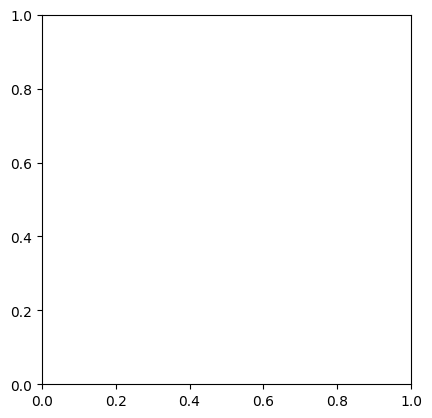

In [ ]:
for images, captions in train_loader:
    images = images.to(device)
    captions = captions.to(device)
    print(captions)
    for idxs in captions.tolist():
        sent = [vocabulary.itos[idx] for idx in idxs]
        print(sent)
        break
    plt.imshow(images[0].cpu())
    break
    predictions, alphas = model(images, captions)
    indexes = predictions.argmax(dim=-1)
    for idx in indexes.tolist():
        sent = [vocabulary.itos[idx] for idx in idx]
        print(sent)
    break

### What happens in validation

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])
device = "cpu"
if torch.cuda.is_available():
    device = "cpu"
elif torch.backends.mps.is_available():
    device="mps"

print(f"Currently using the {device} device")
train_loader, dataset = get_loader(data_dict=train_data, transform=transform, vocabulary=vocabulary, image_folder="data/images/")
captioner = Caption(512, 512, 512, 512, len(vocabulary))
capitoner = model
captioner.to(device)
captioner.train()
for idx, (images, captions) in enumerate(train_loader):
    images= images.to(device)
    captions = captions.to(device)
    predictions, alpha = captioner(images, captions)
    words_idx = predictions.argmax(dim=-1)
    print(f"Shape of the cations batch: {captions.shape}")
    print(f"Shape of the prediction batch:{predictions.shape}")
    print(f"shape of word idx: {words_idx.shape}")
    print(f"shape of the alpha batch: {alpha.shape}")
    print(f"done with idx: {idx}")
    break


Currently using the mps device


/Users/ngkuissi/miniforge3/envs/ImageCap/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Shape of the cations batch: torch.Size([32, 20])
Shape of the prediction batch:torch.Size([32, 20, 8508])
shape of word idx: torch.Size([32, 20])
shape of the alpha batch: torch.Size([32, 20, 196])
done with idx: 0


In [ ]:
image_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.to(device)
model.caption_img(image_tensor, vocab=vocabulary)

RuntimeError: Placeholder storage has not been allocated on MPS device!